# OBTENCION DE DATOS
**IMPORTAR LIBRERIAS Y OBTENER EL DATASET**

En primer lugar, importaremos las siguientes librerias necesarias para el analisis y procederemos a leer y mostrar el dataset.

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.0f}'.format
warnings.filterwarnings('ignore')

In [6]:
url ='https://raw.githubusercontent.com/simonzanetti/2023.2-SysArmy-IT-Salaries-Survey/main/dataset.csv'
df = pd.read_csv(url)

#display(df.head(1))
#print("Shape: " + str(df.shape))

# PREPROCESAMIENTO
**ORDENAR COLUMNAS**

El primer paso de nuestra limpieza sera traducir al ingles el nombre de las columnas y eliminar aquellas que no sean relevantes para el analisis. Tambien ordene las columnas en las categorias:
- Empleado
- Trabajo
- Empresa
- Sueldo
- Herramientas
- Estudios

Las columnas eliminadas fueron:
- 'work_country': La totalidad de los encuestados es de Argentina
- 'ARS/USD_exchange': No solo que el porcentaje de los que cobra parte o la totalidad de su sueldo en dolares es pequeño, sino tambien que existen varios tipos de cotizacion y no se aclara cual se usa en cada caso, ademas que la cotizacion suele variar segun las semanas, horas o dias, por lo que es una variable inestable y he decidido eliminarla.
- 'is:number': Una variable que no vamos a utilizar.

In [8]:
columns_names = ['work_country','work_province','work_dedication','work_contract_type',
                'last_month_gross_salary','last_month_net_salary','salary_in_usd',
                'ARS/USD_exchange','salary_has_bonus','salary_bonus_tied_to',
                '2023_salary_adjusment_times','percentage_adjustment',
                'last_adjustment_month','last_semester_salary_comparison',
                'work_benefits','salary_satisfaction','work_title','years_experience',
                'years_in_company','years_in_position','people_in_charge','platforms',
                'programming_languages','frameworks','databases','qa_testing_tools',
                'company_size','work_mode','office_days_number(hybrid)','work_place_satisfaction',
                'AI_tools_use','finish_survey(1)','highest_level_studies','status','degree/specialization',
                'university/school','finish_survey(2)','work_on-call_duty','salary_on-call_duty',
                'is_number','finish_survey(3)','age','gender']

for i, nuevo_nombre in enumerate(columns_names):
    df.rename(columns={df.columns[i]: nuevo_nombre}, inplace=True)

salaries = pd.concat([df.iloc[:,0:2],df.iloc[:,41:],df.iloc[:,16],
                      df.iloc[:,2:4],df.iloc[:,17:21],df.iloc[:,26:30],
                      df.iloc[:,4:16],df.iloc[:,21:26],df.iloc[:,30:41]],axis=1)

salaries.drop(inplace=True, columns=[
                                    'work_country','ARS/USD_exchange','2023_salary_adjusment_times',
                                    'percentage_adjustment','last_adjustment_month',
                                    'last_semester_salary_comparison','finish_survey(1)','finish_survey(2)',
                                    'work_on-call_duty','salary_on-call_duty','is_number','finish_survey(3)'
                                    ])

#print(salaries.dtypes)

**LIMPIEZA Y TRANSFORMACION DE NANS**

In [9]:
print('Cantidad de Nans antes de la limpieza: ')
print(salaries.isna().sum()[salaries.isna().sum() > 0])

#SALARY_IN_USD
#print(salaries['salary_in_usd'].unique())
salaries['salary_in_usd'].fillna('No cobro mi salario en dolares',inplace=True)

#TOOLS
salaries.loc[:, 'platforms':'AI_tools_use'] = salaries.loc[:, 'platforms':'AI_tools_use'].fillna('Ninguna de las anteriores')

#STUDIES
#print(df['finish_survey(1)'].unique())
#print(df['highest_level_studies'].unique())
for columns in ('highest_level_studies','status','degree/specialization','university/school'):
    salaries.loc[(df['finish_survey(1)'] == 'Terminar encuesta') |
                 (df['finish_survey(1)'] == 'Responder sobre guardias'), columns] = 'Prefiero no responder'

for columns in ('degree/specialization','university/school'):
    salaries.loc[(df['highest_level_studies'] == 'Secundario'), columns] = 'Prefiero no responder'

print('\nCantidad de Nans despues de la limpieza: ')
print(salaries.isna().sum()[salaries.isna().sum() > 0])

Cantidad de Nans antes de la limpieza: 
last_month_net_salary     239
salary_in_usd            3865
platforms                   2
programming_languages       2
frameworks                  3
databases                   3
qa_testing_tools            5
highest_level_studies    3192
status                   3192
degree/specialization    3284
university/school        3767
dtype: int64

Cantidad de Nans despues de la limpieza: 
last_month_net_salary    239
degree/specialization     15
university/school        350
dtype: int64


**LIMPIEZA DE DUPLICADOS**


**NORMALIZACION DE VALORES**

En algunas columnas de este dataset nos encontraremos con una gran dispersion de opciones, con valores incorrectos o con valores que no representan de forma adecuada la respuesta del encuestado. Debido a ello necesitamos realizar una normalizacion de valores, en algunos casos en formato string y en otros casos en formato numerico.

Con la necesidad de reducir el tamaño del codigo, he creado una funcion que toma un dataset, una columna y un diccionario que contiene un mapeo regex, devolviendo un nuevo dataset normalizado.

Mediante el metodo pd.nunique() podemos ver la cantidad de opciones por cada variable, notando ciertas irregularidades:
- **'gender'**: Presenta 144 opciones diferentes de generos, lo cual nos muestra que exste una dispersion erronea en los datos.
- **'work title'**: Presenta una gran dispersion de valores.
- **'people_in_charge'**: Hay 58 opciones que varian entre 0 y 300. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.  
- **'company_size'**: Hay 11 categorias que varian entre 0 y 10000. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.
- **'office_days_number(hybrid)'**: Las opciones '0' y '5' no son correctas, ya que representan a los empleados que o no van nunca a la oficina o que van todos los dias, lo cual no condice con el modo de trabajo hibrido. Se necesita un analisis previo antes de normalizar.



In [38]:
def normalize_dataframe(df_in, column_name, regex_assign_map):
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        print("\nElementos de " + str.capitalize(column_name) + " que integran la categoria " + regex)
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        print(df_in[df_out[column_name].str.strip().str.match(compiled_regex, na=False)][column_name].unique())
        df_out.loc[mask, column_name] = value
    return df_out
print("Cantidad de valores que toma cada variable: ")
print(salaries.nunique())

Cantidad de valores que toma cada variable: 
work_province                   24
age                             58
gender                         144
work_title                     418
work_dedication                  2
work_contract_type               5
years_experience                59
years_in_company                50
years_in_position               46
people_in_charge                58
company_size                    11
work_mode                        3
office_days_number(hybrid)       6
work_place_satisfaction         11
last_month_gross_salary       2173
last_month_net_salary         2075
salary_in_usd                    4
salary_has_bonus                 5
salary_bonus_tied_to           216
work_benefits                 2101
salary_satisfaction              4
platforms                     1288
programming_languages         1446
frameworks                    1269
databases                     1195
qa_testing_tools               599
AI_tools_use                     6
highest_le

**EMPLOYEE**

In [39]:
#GENERO
#print(salaries['gender'].unique())

salaries = normalize_dataframe(salaries, 'gender',
    {
        "^(?!.*(mujer)).*hombre.*|.*macho.*|.*masculino.*|^(?!.*(?:trans|bi|\b(var[oó]n cis)\b))var[oó]n" : "Varón Cis",
        "^(?!.*(?:trans|bi|ag[eé]nero|var[oó]n)).*mujer" : "Mujer Cis",
        "^(?=.*mujer|var[oó]n)(?=.*trans)(?!.*nb).*" : "Trans",
        "^(?=.*mujer|var[oó]n)\b(bi)\b" : "Bisexual",
        ".*ag[eé]nero.*" : "Agenero",
        ".*ag[eé]nero.*" : "Agenero",
        ".*nb.*|.*no binario.*|.*no binarie.*" : "No binario",
    })


Elementos de Gender que integran la categoria ^(?!.*(mujer)).*hombre.*|.*macho.*|.*masculino.*|^(?!.*(?:trans|bi|(var[oó]n cis)))var[oó]n
['Varón Cis' 'Hombre' 'Varon' 'Masculino'
 'BIEN MACHO Y PORONGUDO. QUE CLASE DE OPCIONES DE MIERDA SON ESTAS?'
 'Hombre..... tipo normal' 'varon, no se que es varon cis' 'hombre'
 'Varón' 'masculino' 'Hombre, macho silencioso' 'varón' 'Macho'
 'Porque tantas opciones? Solo hay 2. Soy hombre.' 'Machote'
 'Hombre    (sexo cromosómico:  XY)' 'yo que se que es todo eso masculino'
 'Hombre heterosexual' 'Varon heterosexual' 'Hombre normal'
 'Varón Cis, pero considero ofensivo el término y esta pregunta.' 'HOMBRE'
 'Varón común' 'Hombre Heterosexual' 'Hombre Hetero' 'Hombre Normal'
 'varon' 'Hombre. Varon.' 'Hombre. Nada de pelotudeces.'
 'Soy hombre, el resto no se que significa'
 'Que ganas de joder. Hombre heterosexual.'
 'Masculino, Hombre, no encontré la opción correcta' 'Hombre con pene'
 'Varon macho pecho peludo, dejen de agregar tantas opcione

**WORK**

In [ ]:
#WORK_TITLE
print(salaries['work_title'].unique())

salaries1 = normalize_dataframe(salaries, 'work_title',
    {

    })

In [ ]:
#PEOPLE_IN_CHARGE
#ESPERAR ANALISIS
print(sorted(salaries['people_in_charge'].unique()))
#sns.countplot(x=salaries['people_in_charge'], color='steelblue')
sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')

In [24]:
# WORK_CONTRACT TYPE
for index, valor in enumerate(salaries['work_contract_type']):
    if salaries.iloc[index,5] == 'Tercerizado (trabajo a través de consultora o agencia)':
        salaries.iloc[index,5] = 'Tercerizado'
    if salaries.iloc[index,5] == 'Participación societaria en una cooperativa':
        salaries.iloc[index,5] = 'Participación societaria'

**COMPANY**

In [ ]:
#COMPANY_SIZE
#ESPERAR ANALISIS
salaries['company_size'] = salaries['company_size'].str.replace(r'\bDe\b|\bpersonas\b', '', regex=True).str.strip()
salaries['company_size'].replace({'1 (solamente yo)' : '1','11  a 50' : '11 a 50'})
print(sorted(salaries['company_size'].unique()))
sns.countplot(y=salaries['company_size'], color='steelblue',order=salaries['company_size'].value_counts().index)
#sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')

In [ ]:
#OFFICE_DAYS_NUMBER
#ESPERAR ANALISIS
print(sorted(salaries['office_days_number(hybrid)'].unique()))
#sns.countplot(y=salaries['office_days_number(hybrid)'], color='steelblue',order=salaries['office_days_number(hybrid)'].value_counts().index)
sns.heatmap(pd.crosstab(salaries['office_days_number(hybrid)'], salaries['work_mode']), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
'''
ES NECESARIO ALGUN TIPO DE CLUSTERING PARA AGRUPAR
#WORK_PLACE_SATISFACTION
#print('work_place_satisfaction'].unique())
salaries['work_place_satisfaction'] = salaries['work_place_satisfaction'].replace({
                                                            1:'Muy insatisfecho',2:'Muy insatisfecho',
                                                            3:'Escasamente satisfecho',4:'Escasamente satisfecho',5: 'Escasamente satisfecho',
                                                            6:'Ampliamente satisfecho',7:'Ampliamente satisfecho',8: 'Ampliamente satisfecho',
                                                            9:'Muy satisfecho',10:'Muy satisfecho'
                                                            })
'''

"\nES NECESARIO ALGUN TIPO DE CLUSTERING PARA AGRUPAR\n#WORK_PLACE_SATISFACTION\n#print('work_place_satisfaction'].unique())\nsalaries['work_place_satisfaction'] = salaries['work_place_satisfaction'].replace({\n                                                            1:'Muy insatisfecho',2:'Muy insatisfecho',\n                                                            3:'Escasamente satisfecho',4:'Escasamente satisfecho',5: 'Escasamente satisfecho',\n                                                            6:'Ampliamente satisfecho',7:'Ampliamente satisfecho',8: 'Ampliamente satisfecho',\n                                                            9:'Muy satisfecho',10:'Muy satisfecho' \n                                                            })\n"

**SALARY**

In [ ]:
#SALARY_SATISFACTION
#print(salaries['salary_satisfaction'].unique())
salaries['salary_satisfaction'] = salaries['salary_satisfaction'].replace({
                                                            1:'Muy insatisfecho',2:'Escasamente satisfecho',
                                                            3:'Ampliamente satisfecho',4:'Muy satisfecho'
                                                            })

**TOOLS**

In [36]:
def normalize_tools(column):
    value_counts_series = (column.str.extractall(r"(?P<count>[^,]+),? ?")["count"].value_counts(sort=True))
    df_out = pd.DataFrame({'tool': value_counts_series.index, 'counts': value_counts_series.values})
    return df_out

In [ ]:
#PLATFORMS
platforms_count = normalize_tools(salaries['platforms'])

#PROGRAMMING_LENGUAGES
programming_languages_count = normalize_tools(salaries['programming_languages'])

#FRAMEWORKS
frameworks_count = normalize_tools(salaries['frameworks'])

#DATABASES
databases_count = normalize_tools(salaries['databases'])

#QA_TESTING_TOOLS
qa_testing_tools_count = normalize_tools(salaries['qa_testing_tools'])

#AI_TOOLS_USE
#print(salaries['AI_tools_use'].unique())
salaries['AI_tools_use'] = salaries['AI_tools_use'].replace({
                                                            0:'No utilizadas',1:'Escasamente utlizadas',
                                                            2:'Escasamente utlizadas',3:'Ampliamente utilizadas',
                                                            4:'Ampliamente utilizadas',5:'Muy utilizadas'
                                                            })


['No utilizadas' 'Escasamente utlizadas' 'Ampliamente utilizadas'
 'Muy utilizadas']


**STUDIES**

In [ ]:
#DEGREE/SPECIALIZATION
#print(salaries['degree/specialization'].unique())

salaries1 = normalize_dataframe(salaries, 'degree/specialization',
    {
        ".*ingenier[ií]a.* .*sistemas.*" : "Ingenieria en Sistemas",
        #".*ana.* .*sistema.* " : "Analista de Sistemas",
        ".*empresa.* " : "Administracion de Empresas",
        ".*economia.* " : "Lic. en Economia",
        ".*desarrollo.* .*web.*" : "Tec. en Desarrollo Web",
        ".*desarrollo.* .*movil.*" : "Tec. en Desarrollo de Aplicaciones Moviles",
        ".*desarrollo.* .*software.*" : "Tec. en Desarrollo de Software",
        ".*juego.* .*game.*" : "Tec. en Desarrollo de Videojuegos",
        "^(?!.*(?:higiene|lic|master|esp)).*seguridad.*" : "Tec. en Ciberseguridad/ Seguridad Informatica",
        "^(?!.*(?:higiene|tec|master|esp)).*seguridad.*" : "Lic. en Ciberseguridad/ Seguridad Informatica",
        ".*tec.* .*redes.*" : "Tec. en Redes Informaticas y Telecomunicaciones",
        ".*lic.* .*redes.*" : "Lic. en Redes Informaticas y Telecomunicaciones",
        "^(?!.*(?:sistema))(?=.*lic.* .*computaci[oó]n.*)" : "Lic. en Ciencia de la Computación",
        ".*ing.* .*computaci[oó]n.*" : "Ingeniería en Computación",
        ".*ana.* .*computaci[oó]n.*" : "Analista en Computación",
        ".*computaci[oó]n.*" : "Ingeniería en Computación",
        #".*dat.* " : "Tec. en Desarrollo de Software",
        #".*lic.* " : "Tec. en Desarrollo de Software",
        #"^(?!.*(?:robot|admin))(?=.*lic.*sistemas)" : "Licenciatura en Sistemas",
    })


In [ ]:
fig = plt.figure(figsize=(15, 60))
ax = sns.countplot(data=(salaries1['degree/specialization'].value_counts(normalize=True) * 100) > 10,y=salaries1['degree/specialization'], color='steelblue', order=salaries1["degree/specialization"].value_counts().index)
plt.title("Distribucion de encuestados por estudios",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

In [ ]:
print("Cantidad de valores que toma cada variable despues de la normalizacion: ")
print(salaries.nunique())

# EDA: ANALISIS  MONOVARIABLE


**FUNCIONES AUXILIARES**

In [97]:
def boxplot_values(column):
    percentiles = np.percentile(salaries[column], [25, 50, 75])
    Q1 = percentiles[0]
    Q3 = percentiles[2]
    IQR = Q3 - Q1
    max_fence = Q3 + 1.5*IQR
    min_fence = Q1 - 1.5*IQR
    return IQR,max_fence,min_fence,percentiles

def boxplot_plotting_values(column_name, subplot):
    IQR, max_fence, min_fence, percentiles = boxplot_values(column_name)
    if min_fence <= 0:
        min_fence = 0
    else:
        min_fence = percentiles[0] - 1.5 * IQR

    subplot.annotate(f'{int(percentiles[0])}', xy=(percentiles[0], 0), xytext=(percentiles[0] - 2, 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[1])}', xy=(percentiles[1], 0), xytext=(percentiles[1], 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[2])}', xy=(percentiles[2], 0), xytext=(percentiles[2] + 2, 0.45), fontsize=7)

    for i, outlier_limit in enumerate([min_fence, max_fence]):
        subplot.annotate(f'{int(outlier_limit)}', xy=(outlier_limit, 0), xytext=(outlier_limit - 1.5, 0.25))

**EMPLOYEE**

> work_province: El 50% de los encuestados proviene de CABA.  



- age: Existen valores fuera de rango

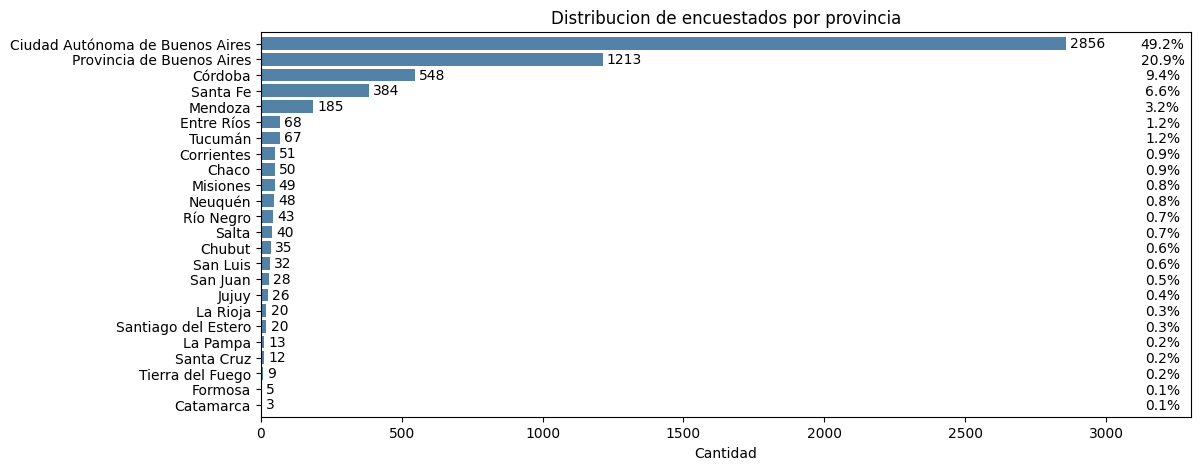

In [59]:
#WORK_PROVINCE
fig = plt.figure(figsize=(12, 5))
ax = sns.countplot(y=salaries['work_province'], color='steelblue', order=df["work_province"].value_counts().index)
plt.title("Distribucion de encuestados por provincia",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#plt.xscale('log')
ax.set_xlim(0,3300)
ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

total = len(salaries)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    ax.annotate(percentage, (3200, (p.get_y() + p.get_height() / 2) + 0.5), ha='center', va='bottom', fontsize=10)

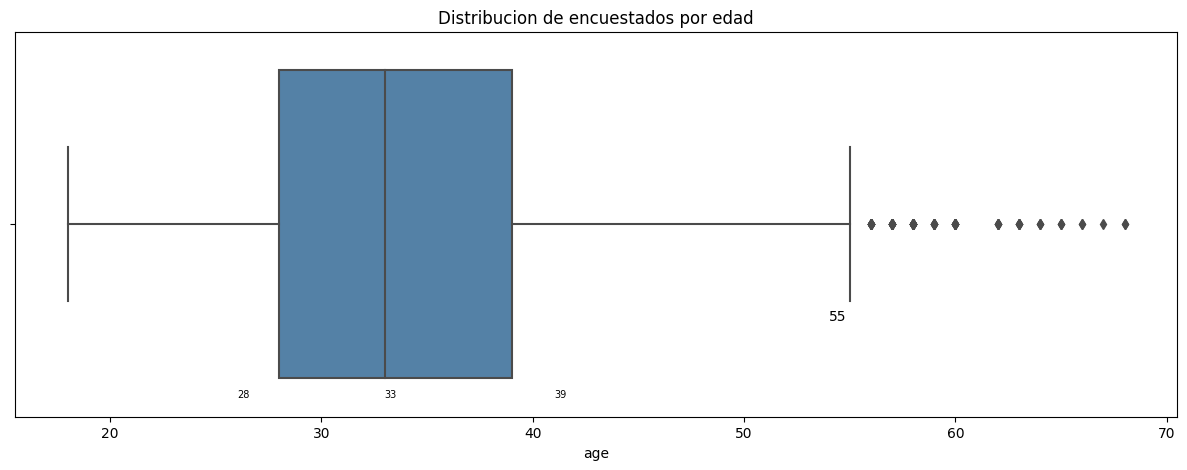

In [98]:
#AGE
fig = plt.figure(figsize=(15, 5))
ax = sns.boxplot(salaries[stats.zscore(salaries['age']) < 3],x ='age', color='steelblue')
plt.title("Distribucion de encuestados por edad",loc='center')

boxplot_plotting_values('age',ax)

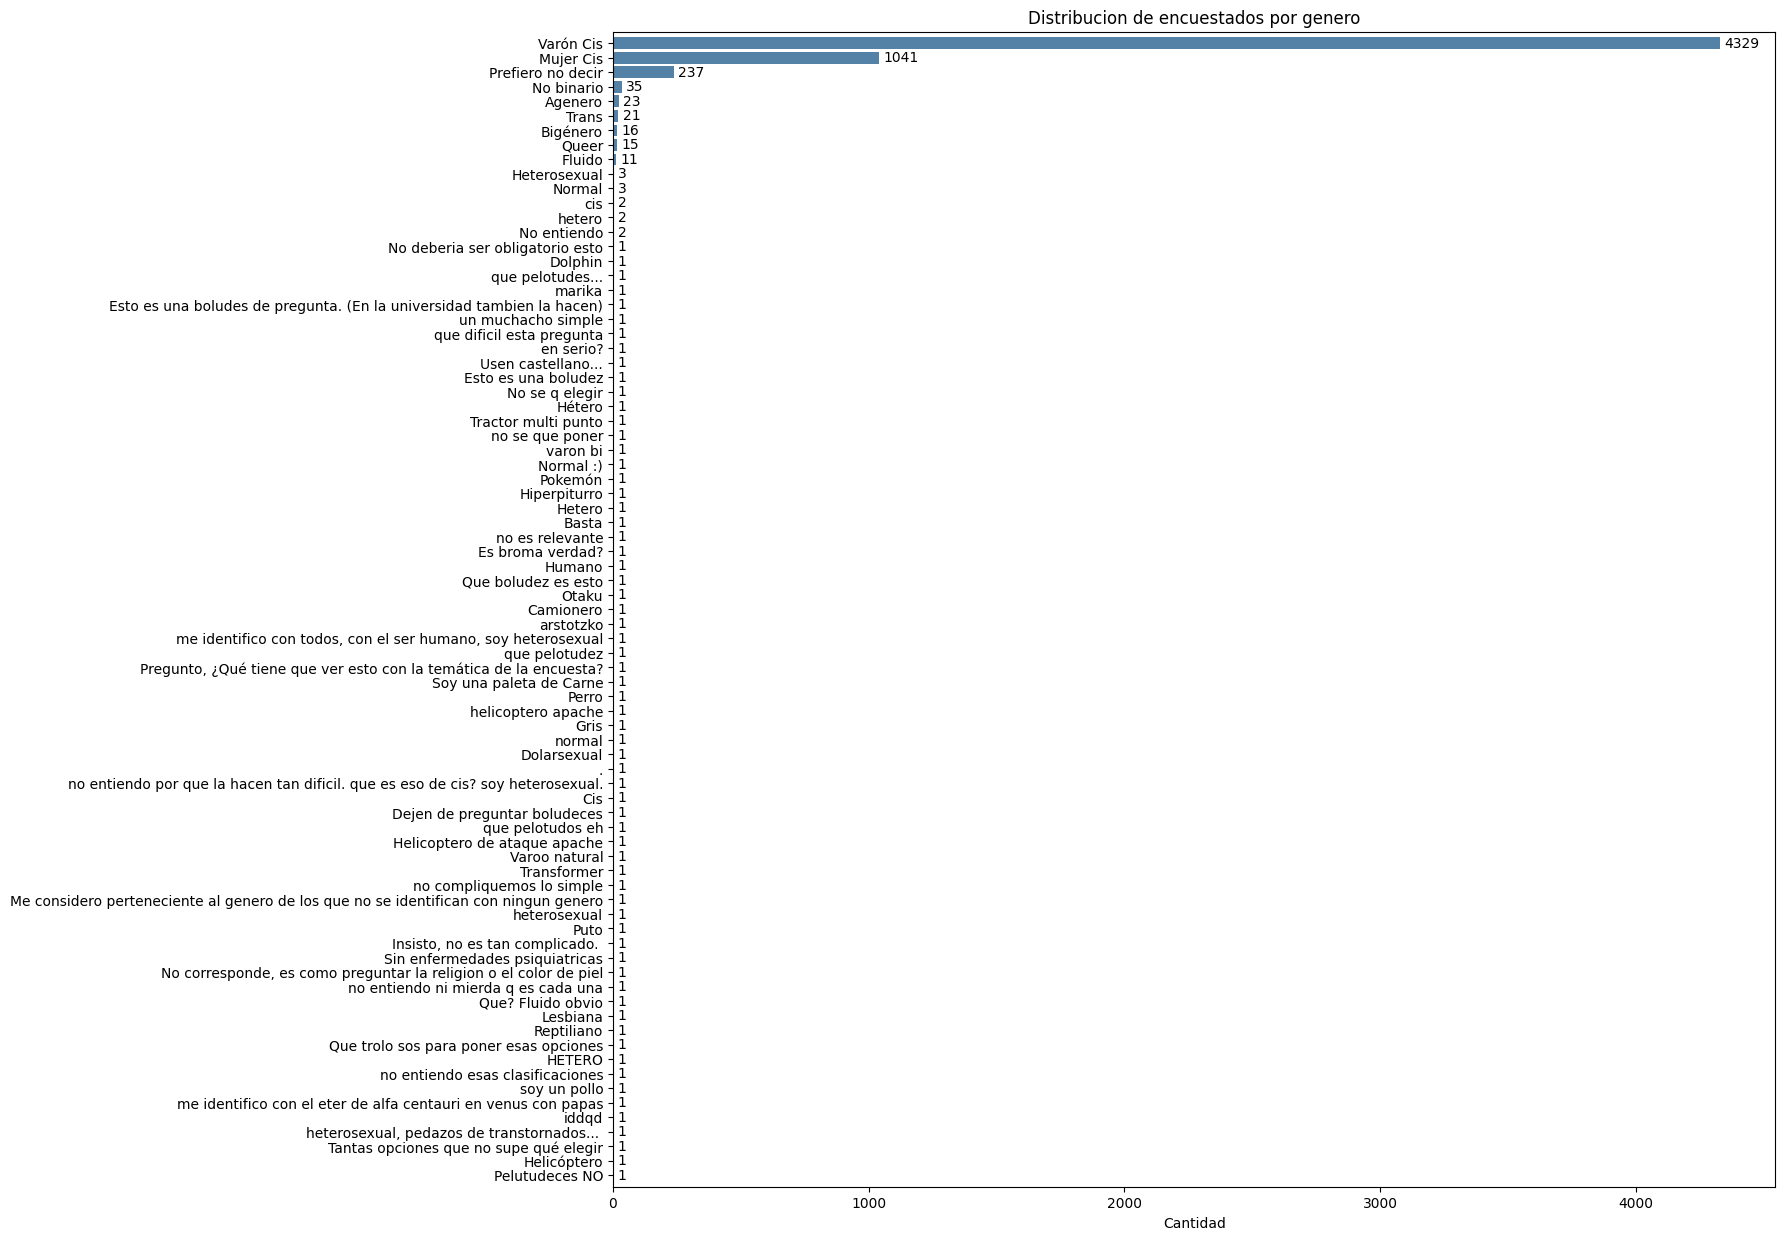

In [40]:
#GENDER
fig = plt.figure(figsize=(15, 15))
ax = sns.countplot(y=salaries['gender'], color='steelblue', order=salaries["gender"].value_counts().index)
plt.title("Distribucion de encuestados por genero",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
plt.bar_label(ax.containers[0], padding=3, fontsize = 10)
ax.margins(y=0.005)

**WORK**

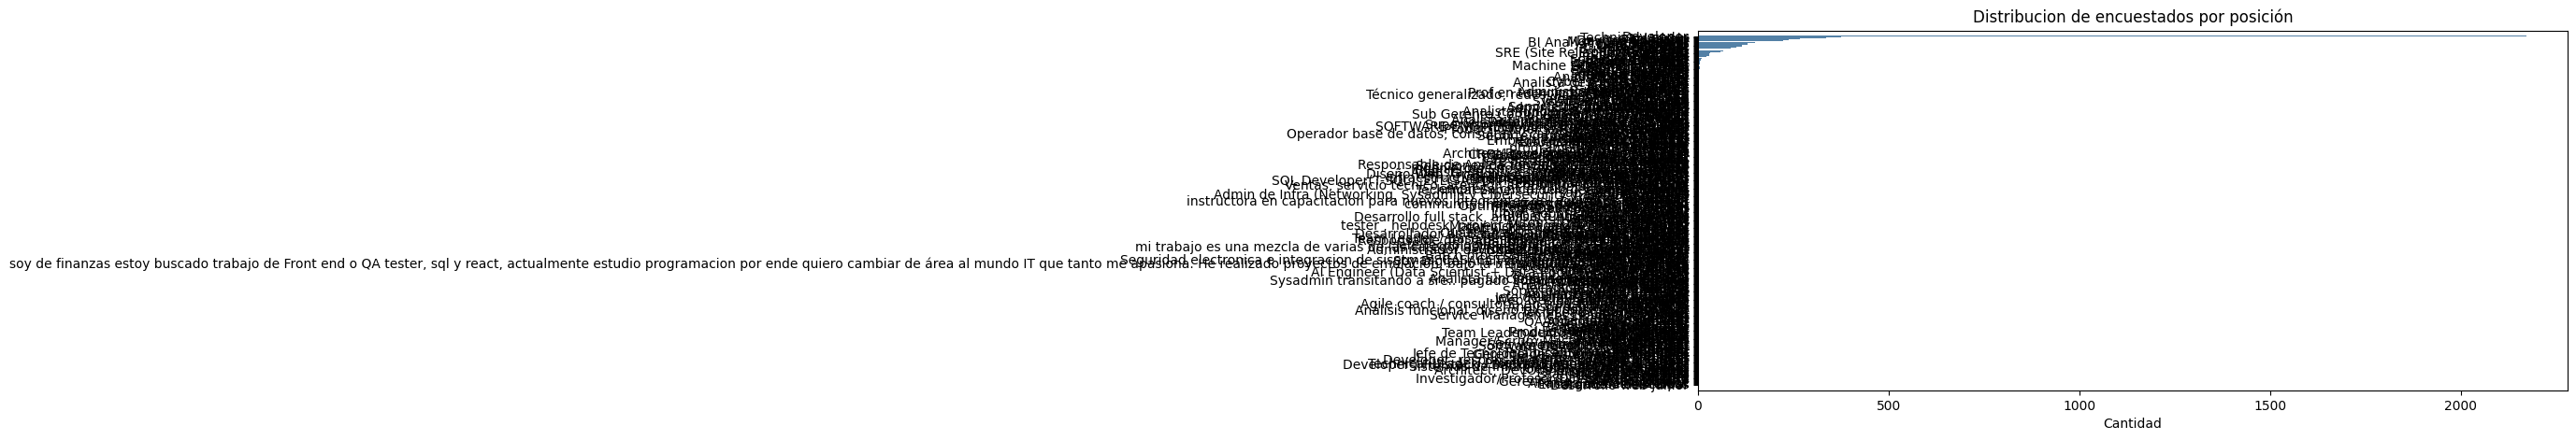

In [ ]:
#WORK_TITLE
fig = plt.figure(figsize=(12, 5))
ax = sns.countplot(y=salaries['work_title'], color='steelblue', order=df["work_title"].value_counts().index)
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

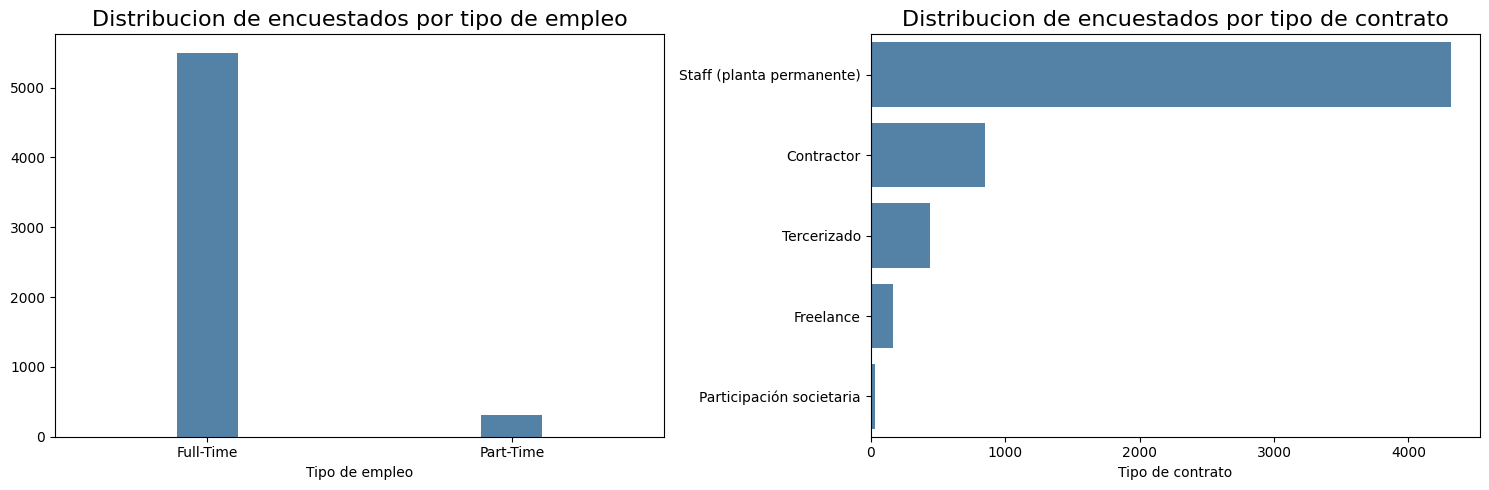

In [45]:
# WORK_DEDICATION
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.countplot(x=salaries['work_dedication'], color='steelblue',width=0.2,ax=axes[0])
axes[0].set_xlabel("Tipo de empleo")
axes[0].set_ylabel('')
axes[0].set_title("Distribucion de encuestados por tipo de empleo", fontsize=16)

ax2 = sns.countplot(y=salaries['work_contract_type'], color='steelblue',order=salaries["work_contract_type"].value_counts().index,ax=axes[1])
axes[1].set_title("Distribucion de encuestados por tipo de contrato", fontsize=16)
axes[1].set_xlabel("Tipo de contrato")
axes[1].set_ylabel('')

plt.tight_layout()

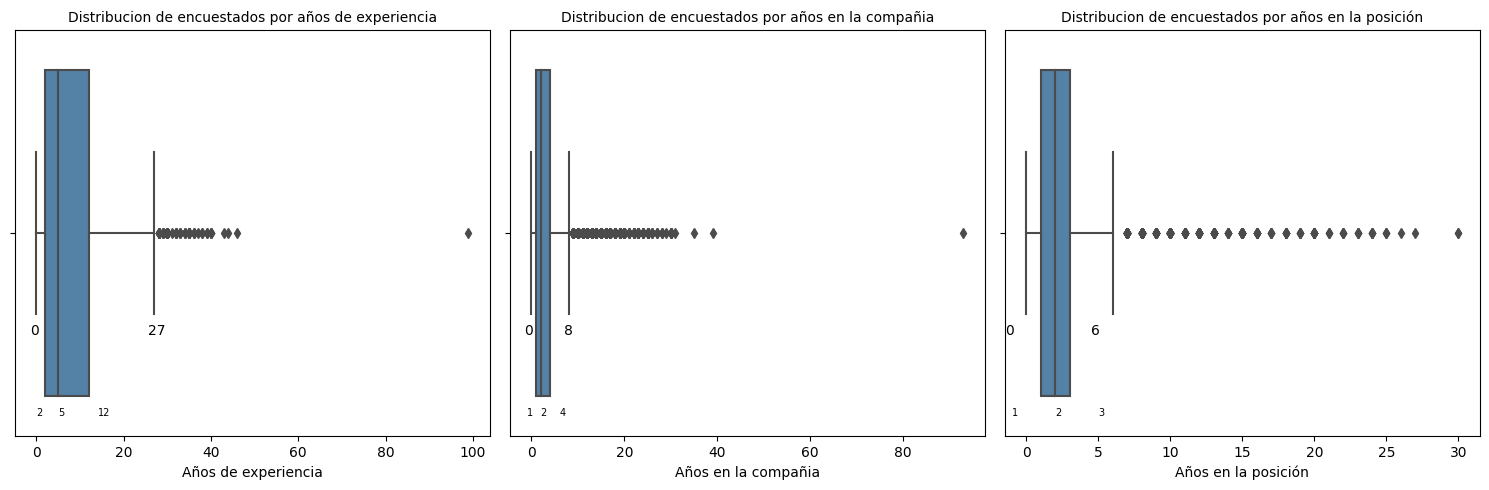

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def years (column,subplot,xlabel,title):
    sns.boxplot(x=salaries[column], color='steelblue', ax=subplot)
    subplot.set_xlabel(xlabel)
    subplot.set_label('')
    subplot.set_title(title, fontsize=10)
    plt.tight_layout()

    boxplot_plotting_values(column,subplot)

years('years_experience',axes[0],'Años de experiencia',"Distribucion de encuestados por años de experiencia")
years('years_in_company',axes[1], 'Años en la compañia', "Distribucion de encuestados por años en la compañia")
years('years_in_position',axes[2], 'Años en la posición', "Distribucion de encuestados por años en la posición")


**COMPANY**

<Axes: xlabel='count', ylabel='work_place_satisfaction'>

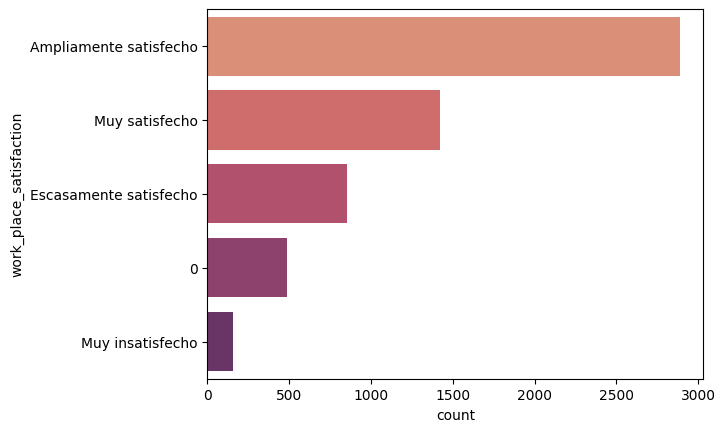

In [ ]:
sns.countplot(y=salaries['work_place_satisfaction'], palette='flare',order=salaries['work_place_satisfaction'].value_counts().index)

**SALARIES**

In [ ]:
#LAST_MONTH_GROSS_SALARY
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
filtered_gross_salary = salaries[stats.zscore(salaries['last_month_gross_salary']) < 3.5]
ax = sns.histplot(data=filtered_gross_salary,x='last_month_gross_salary', color='steelblue',ax=axes[0],bins=35)
ax.ticklabel_format(style='plain', axis='both')
ax.bar_label(ax.containers[0], padding=3,fontsize=6)
axes[0].set_title("Distribucion de encuestados por percepción de salario bruto", fontsize=16)

#LAST_MONTH_NET_SALARY
filtered_net_salary = salaries[stats.zscore(salaries[~np.isnan(salaries['last_month_net_salary'])])]
print(filtered_net_salary)
ay = sns.histplot(data=filtered_net_salary,x='last_month_net_salary', color='steelblue',ax=axes[1],bins=35)
ay.ticklabel_format(style='plain', axis='both')
axes[1].set_title("Distribucion de encuestados por tipo de empleo", fontsize=16)

plt.tight_layout()

[Text(3, 0, '3865'), Text(3, 0, '379'), Text(3, 0, '773'), Text(3, 0, '788')]

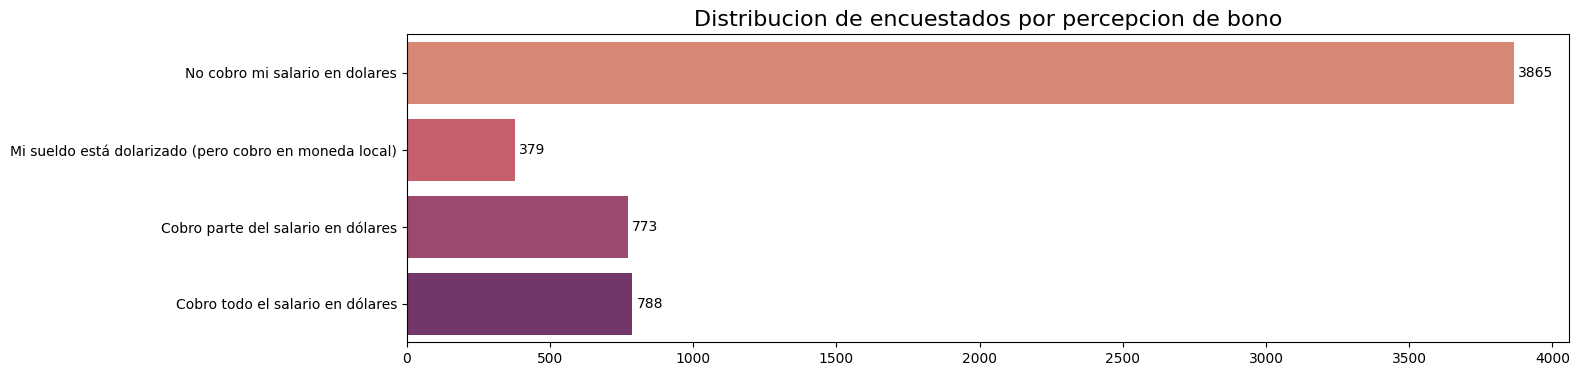

In [ ]:
#SALARY_IN_USD
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_in_usd'],palette='flare',order=['No cobro mi salario en dolares',
                                                                      'Mi sueldo está dolarizado (pero cobro en moneda local)',
                                                                      'Cobro parte del salario en dólares',
                                                                      'Cobro todo el salario en dólares'
                                                                      ])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

[Text(3, 0, '3293'),
 Text(3, 0, '759'),
 Text(3, 0, '755'),
 Text(3, 0, '816'),
 Text(3, 0, '182')]

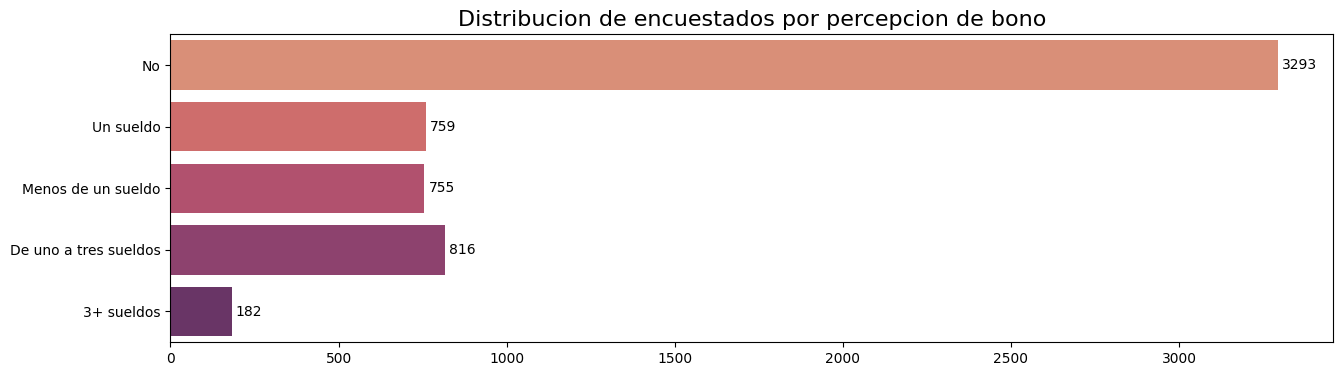

In [ ]:
#SALARY_HAS_BONUS
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_has_bonus'],palette='flare')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

In [ ]:
#SALARY_HAS_BONUS (NORMALIZAR)

In [ ]:
#WORK_BENEFITS (NORMALIZAR)

[Text(3, 0, '2484'), Text(3, 0, '3321'), Text(3, 0, '0'), Text(3, 0, '0')]

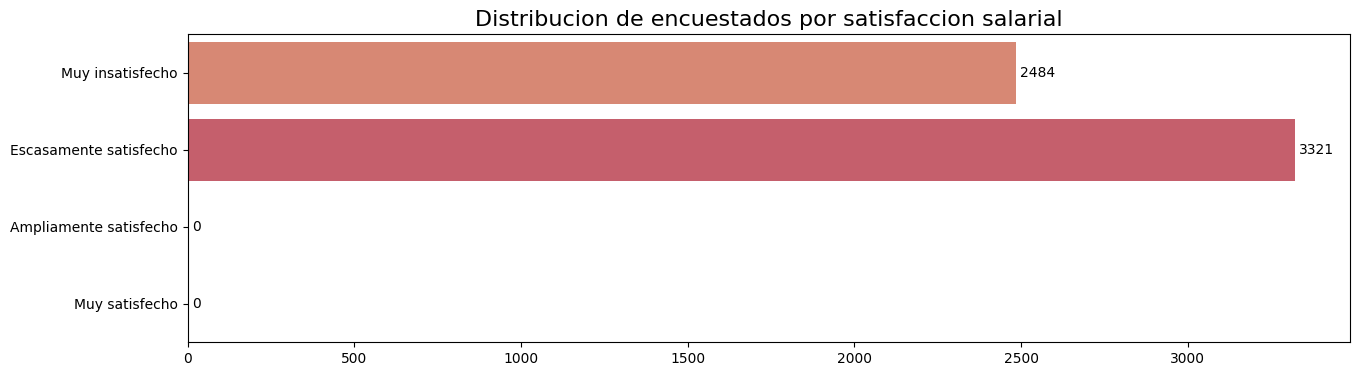

In [ ]:
#SALARY_SATISFACTION
print(salaries[sala])
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_satisfaction'],palette='flare',order=['Muy insatisfecho','Escasamente satisfecho',
                                                                            'Ampliamente satisfecho','Muy satisfecho'])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por satisfaccion salarial', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

**TOOLS**

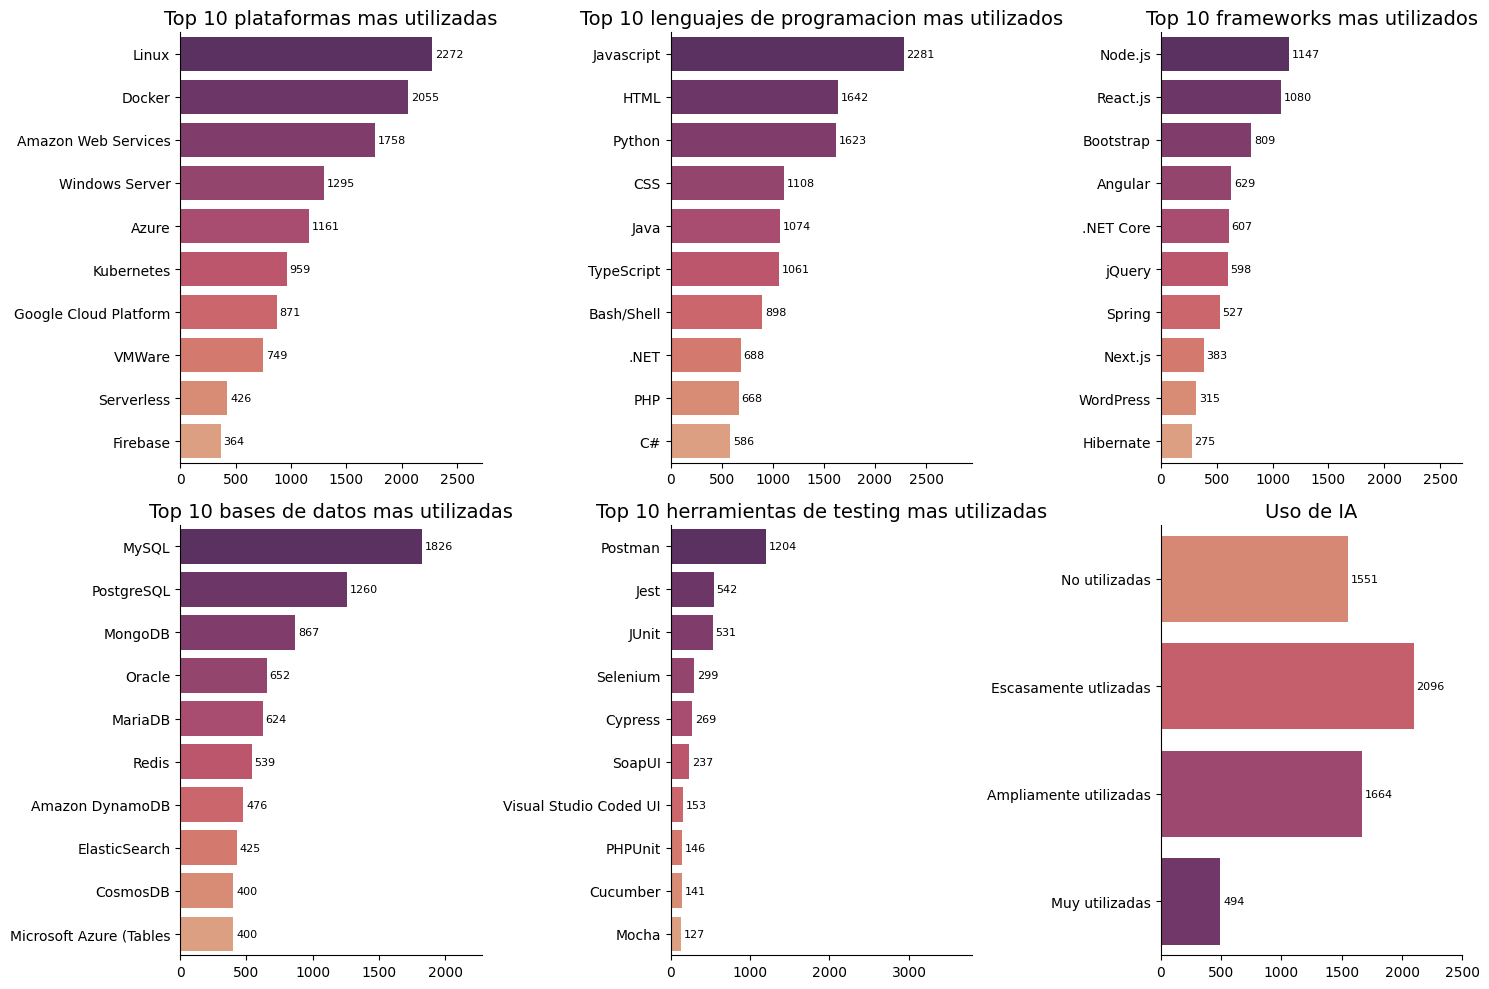

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.despine(top=True)
def plotting_tools(df,subplot,title):
    ax = sns.barplot(data=df[~df['tool'].str.contains(r'Ningun[ao] de l[ao]s anteriores|etc\)|\bSQL\b')].head(10),y='tool',x='counts', ax=subplot, palette='flare' + "_r")
    subplot.set_xlabel('')
    subplot.set_ylabel('')
    subplot.set_title('Top 10 ' + title, fontsize=14)
    subplot.set_xlim(0, df.iloc[0,1] + 450)
    ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plotting_tools(platforms_count,axes[0,0],'plataformas mas utilizadas')
plotting_tools(programming_languages_count,axes[0,1],'lenguajes de programacion mas utilizados')
plotting_tools(frameworks_count,axes[0,2],'frameworks mas utilizados')
plotting_tools(databases_count,axes[1,0],'bases de datos mas utilizadas')
plotting_tools(qa_testing_tools_count,axes[1,1],'herramientas de testing mas utilizadas')

ax = sns.countplot(y=salaries['AI_tools_use'], ax=axes[1,2],palette='flare')
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_title('Uso de IA', fontsize=14)
axes[1,2].set_xlim(0, 2500)
ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plt.tight_layout()

**STUDIES**

Text(0, 0.5, '')

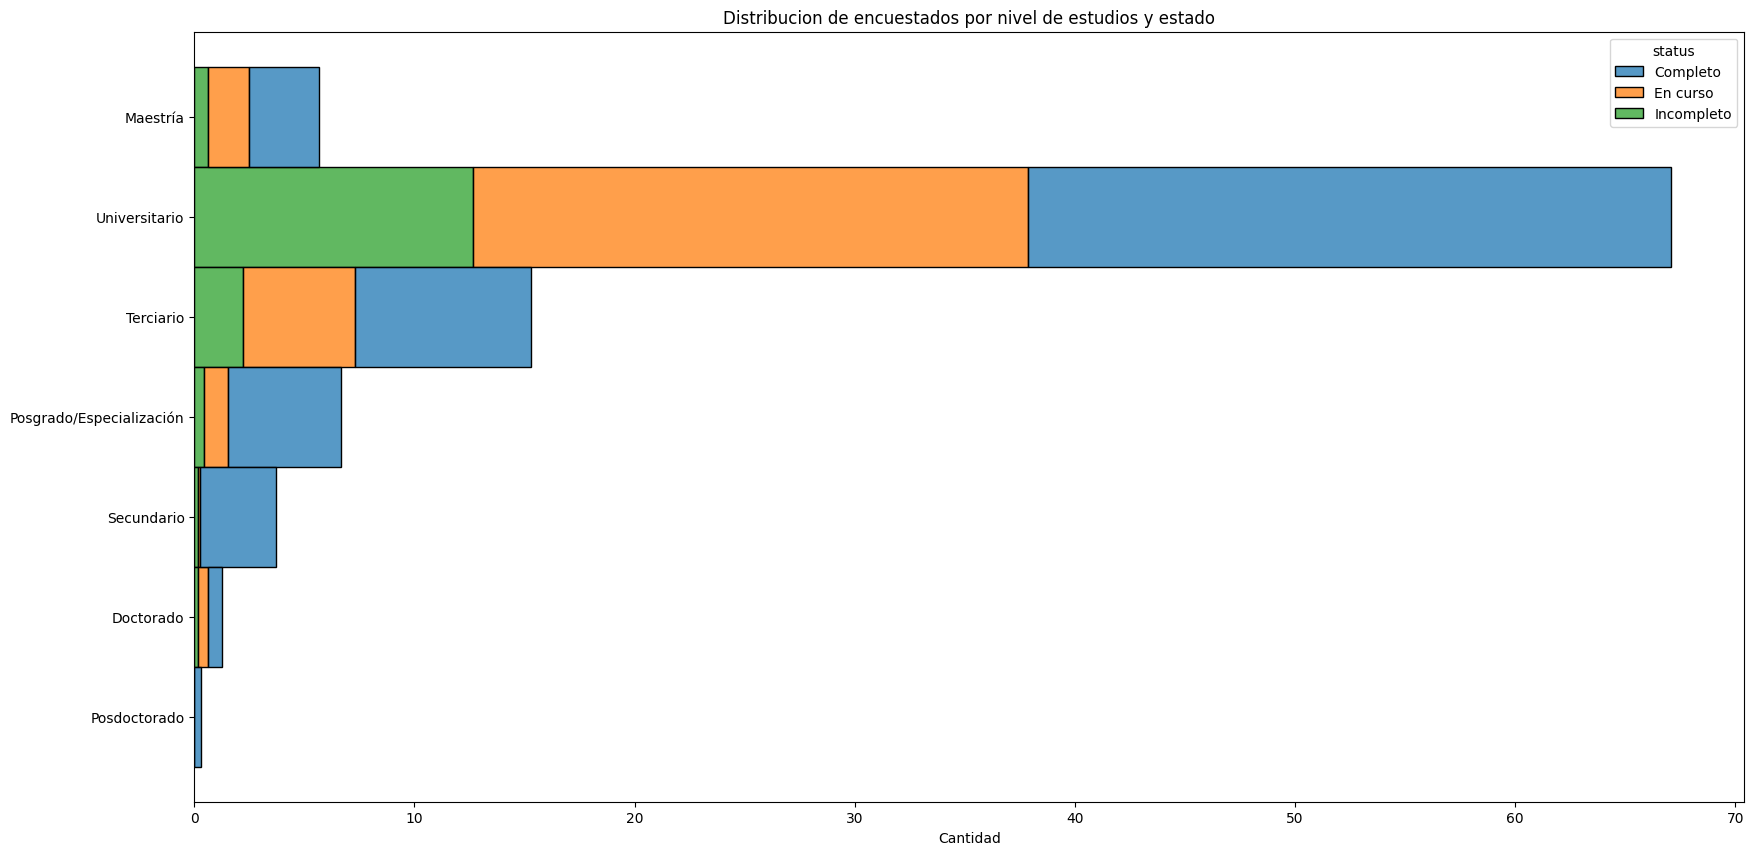

In [ ]:
#HIGHEST_LEVEL_STUDIES AND STATUS
fig = plt.figure(figsize=(20, 10))
ax = sns.histplot(salaries[salaries["highest_level_studies"] != 'Prefiero no responder'],y='highest_level_studies', color='steelblue',hue='status',multiple='stack',stat='percent')
plt.title("Distribucion de encuestados por nivel de estudios y estado",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')


Text(150, 8, 'Cantidad de encuestados en esta categoria: 1818')

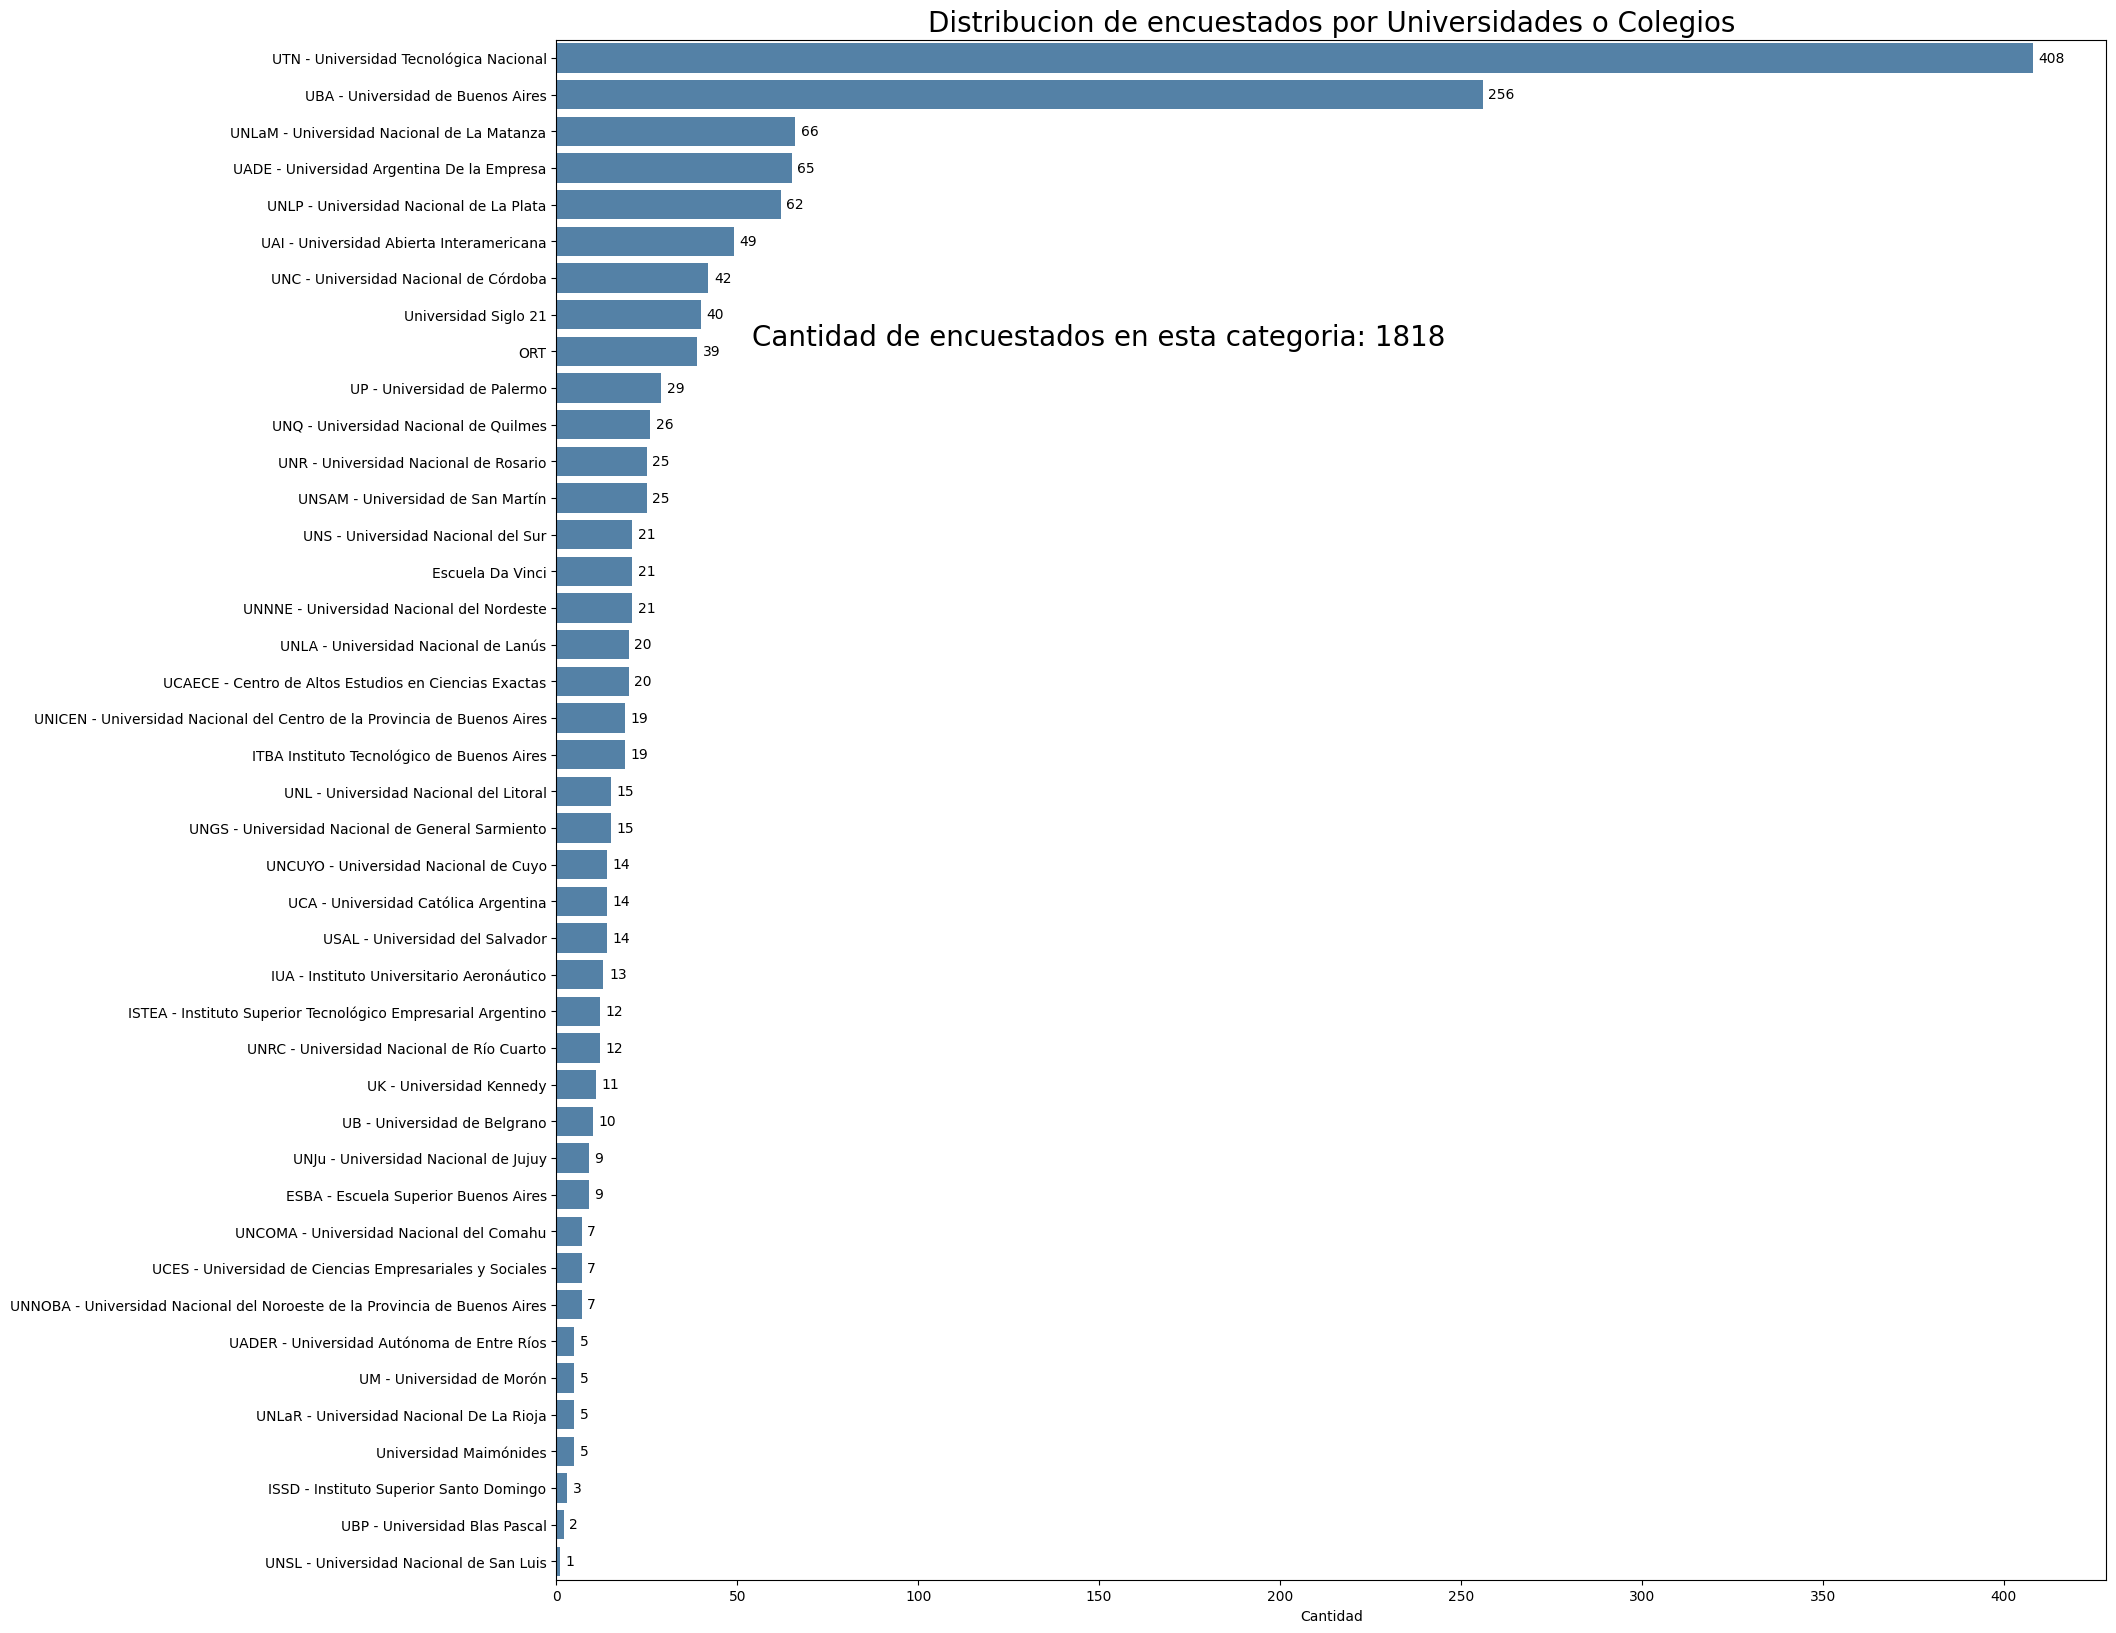

In [ ]:
#UNIVERSITY/SCHOOL
fig = plt.figure(figsize=(20, 20))
ax = sns.countplot(data=salaries[salaries["university/school"] != 'Prefiero no responder'], y="university/school", color='steelblue',
                  order=salaries[salaries["university/school"] != 'Prefiero no responder']["university/school"].value_counts().index)
plt.title("Distribucion de encuestados por Universidades o Colegios", fontsize=20)
plt.xlabel("Cantidad")
plt.ylabel('')
plt.yticks(fontsize=10)
ax.bar_label(ax.containers[0], padding=4)
ax.annotate('Cantidad de encuestados en esta categoria: ' + str((salaries['university/school'] != 'Prefiero no responder').sum()),
             (150, 8), ha='center', va='bottom', fontsize=20)